Binary 1/6 A)


mRNA localization using binary classification (cytoplasm/endoplasmic reticulum) (part 1): basic model with: <br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 2: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance, i.e. PredictionValuesChange) <br>
c) Method 3: with feature importance-based feature selection (feature importance type: SHAP values)

In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [4]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Endoplasmic reticulum (label = 1)
ER_train = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_train_CSV.csv")
ER_test = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("ER TRAIN, TEST SHAPE:", ER_train.shape, ",", ER_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
ER TRAIN, TEST SHAPE: (296, 1026) , (74, 1026)


In [5]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [6]:
#Group 1: CP + ER

frames_EC_tra = [CP_train, ER_train]
frames_EC_tes = [CP_test, ER_test]

CP_ER_train = pd.concat(frames_EC_tra)
CP_ER_test = pd.concat(frames_EC_tes)



In [7]:
print("CP + ER TRAIN, TEST SHAPE:", CP_ER_train.shape, ",", CP_ER_test.shape)


CP + ER TRAIN, TEST SHAPE: (1120, 1026) , (280, 1026)


In [8]:
CP_ER_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_9547#3911|1|testing,1,0.001311,0.000087,0.000262,0.000262,0.000000,0.000437,0.000175,0.000175,...,0.000087,0.000262,0.000175,0.000262,0.001224,0.000612,0.000175,0.000087,0.000175,0.000175
1,mRNALoc_11948#55102|1|testing,1,0.002614,0.000991,0.001893,0.003245,0.001532,0.000811,0.000541,0.001532,...,0.000180,0.002614,0.001442,0.001712,0.002073,0.001532,0.003335,0.002704,0.002524,0.003064


In [9]:
#Remove name/symbol column and separate labels and variables from training and testing data

#FOR CP+ER
noname_CE_train = CP_ER_train.drop("#", axis="columns")
noname_CE_test = CP_ER_test.drop("#", axis="columns")


CP_ER_X_train = noname_CE_train.drop("label", axis="columns")
CP_ER_y_train = noname_CE_train["label"]

CP_ER_X_test = noname_CE_test.drop("label", axis="columns")
CP_ER_y_test = noname_CE_test["label"]

print("CP + ER X train:", CP_ER_X_train.shape)
print("CP + ER y train:", CP_ER_y_train.shape)
print("CP + ER X test:", CP_ER_X_test.shape)
print("CP + ER y test:", CP_ER_y_test.shape)

CP + ER X train: (1120, 1024)
CP + ER y train: (1120,)
CP + ER X test: (280, 1024)
CP + ER y test: (280,)


In [10]:
# Create data pools for feature importance/selection for CP + ER

CE_feature_names = list(CP_ER_X_train.columns)
print("Number of features:", len(CE_feature_names))

CE_train_pool = Pool(CP_ER_X_train, CP_ER_y_train, feature_names=CE_feature_names)

CE_test_pool = Pool(CP_ER_X_test, CP_ER_y_test)

print("*Cytoplasm, ER Pools created")

Number of features: 1024
*Cytoplasm, ER Pools created


    Method 1: Initial classification (without feature importance, selection or auto_class_weights)

In [11]:
CE_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [12]:
#Fit model to CE data

CE_binary_model.fit(CE_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6700853	total: 336ms	remaining: 5m 35s
1:	learn: 0.6515013	total: 572ms	remaining: 4m 45s
2:	learn: 0.6342181	total: 871ms	remaining: 4m 49s
3:	learn: 0.6196763	total: 1.14s	remaining: 4m 43s
4:	learn: 0.6041872	total: 1.39s	remaining: 4m 36s
5:	learn: 0.5892435	total: 1.64s	remaining: 4m 31s
6:	learn: 0.5736680	total: 1.91s	remaining: 4m 30s
7:	learn: 0.5625873	total: 2.13s	remaining: 4m 24s
8:	learn: 0.5530769	total: 2.36s	remaining: 4m 19s
9:	learn: 0.5418085	total: 2.61s	remaining: 4m 18s
10:	learn: 0.5336489	total: 2.86s	remaining: 4m 17s
11:	learn: 0.5259600	total: 3.13s	remaining: 4m 17s
12:	learn: 0.5181220	total: 3.35s	remaining: 4m 14s
13:	learn: 0.5106922	total: 3.63s	remaining: 4m 15s
14:	learn: 0.5033874	total: 3.88s	remaining: 4m 15s
15:	learn: 0.4969499	total: 4.15s	remaining: 4m 14s
16:	learn: 0.4915303	total: 4.38s	remaining: 4m 13s
17:	learn: 0.4867163	total: 4.65s	remaining: 4m 13s
18:	learn: 0.4829952	total: 4.96s	remaining:

In [13]:
#Check parameters used in this model fit

CE_bin_params = CE_binary_model.get_all_params()
print("Basic model parameters:", CE_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [14]:
#Prediction using X_test
CE_y_pred = CE_binary_model.predict(CP_ER_X_test)

#Predication probability

CE_y_prob = CE_binary_model.predict_proba(CP_ER_X_test)

In [15]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Cytoplasm & endoplasmic reticulum")

CE_cr = classification_report(CP_ER_y_test, CE_y_pred, digits=3)
print(CE_cr)

print("Accuracy score: ", accuracy_score(CP_ER_y_test, CE_y_pred))

CE_f1 = f1_score(CP_ER_y_test, CE_y_pred, average='macro')
print(f"\nF1 Score: {CE_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_y_prob))

Model 1: Basic model - Cytoplasm & endoplasmic reticulum
              precision    recall  f1-score   support

           0      0.759     0.981     0.856       206
           1      0.714     0.135     0.227        74

    accuracy                          0.757       280
   macro avg      0.737     0.558     0.542       280
weighted avg      0.747     0.757     0.690       280

Accuracy score:  0.7571428571428571

F1 Score: 0.5416024653312789


In [16]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_y_pred.shape)

CE_y_pred_fl = CE_y_pred
print("flattened prediction values shape:", CE_y_pred_fl.ravel().shape, "\n")

CE_cMatrix = confusion_matrix(CP_ER_y_test, CE_y_pred_fl)
print(CE_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[202   4]
 [ 64  10]]


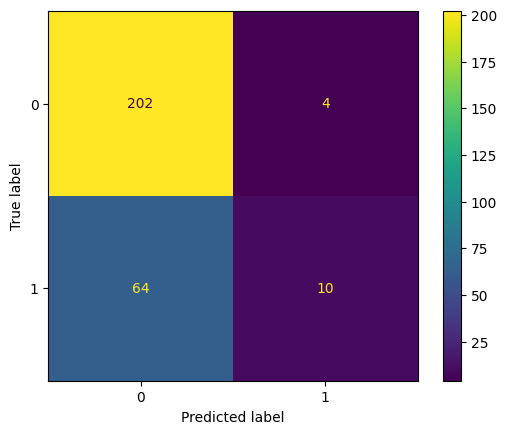

In [17]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_cMatrix, display_labels=CE_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [1]:
#Feature importances for CE pair

CE_feat_importances = CE_binary_model.get_feature_importance(prettified=True)
CE_feat_importances.head(350)

NameError: name 'CE_binary_model' is not defined

In [18]:
# Show only feature importances above 0.1

threshold_chosen_features = CE_feat_importances[CE_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        TCGAA     1.892877
1        TCTCG     1.405180
2        CTTAG     1.263258
3        CTGGT     1.112860
4        AGAAG     0.956090
..         ...          ...
320      ACACT     0.100785
321      AAGCA     0.100707
322      TTCGA     0.100490
323      AGCTC     0.100489
324      TTGCT     0.100399

[325 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 325


In [19]:
print("Sum of total feature importances: ", sum(CE_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999991
Sum of feature importances >=0.1:  72.10830084560675


In [20]:
# Select features with importance values above 0.1

CE_selected_feat = CE_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(CE_selected_feat)

In [21]:
CP_ER_X_train.shape

(1120, 1024)

In [22]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [23]:
#Create training set with selected features 

CE_X_train_selected = CP_ER_X_train[CE_selected_feat]
CE_X_train_selected.head()

,TCGAA,TCTCG,CTTAG,CTGGT,AGAAG,TGGTG,CAAGC,TTTGC,GGGTT,TGAAG,...,AGTGG,GGGCA,TCAGG,ACCTC,CTAGA,ACACT,AAGCA,TTCGA,AGCTC,TTGCT
0,0.000158,0.000792,0.000475,0.000634,0.001742,0.001109,0.001426,0.001109,0.000475,0.002376,...,0.000475,0.001267,0.000634,0.000950,0.000950,0.001109,0.001267,0.000317,0.001584,0.001267
1,0.000583,0.000583,0.000000,0.000874,0.004079,0.001748,0.000583,0.000291,0.000291,0.000874,...,0.002040,0.002914,0.000874,0.001166,0.000291,0.000291,0.000874,0.001166,0.000874,0.000583
2,0.000458,0.000458,0.000917,0.001375,0.002291,0.001375,0.000458,0.000458,0.000917,0.000458,...,0.002291,0.002750,0.000458,0.001833,0.000458,0.001375,0.001375,0.000917,0.000458,0.000000
3,0.000000,0.000000,0.000990,0.000495,0.000990,0.001484,0.001484,0.000000,0.000990,0.000495,...,0.002474,0.003958,0.000495,0.001484,0.000990,0.001979,0.000495,0.000990,0.001979,0.000495
4,0.000104,0.000415,0.000933,0.000415,0.001659,0.001451,0.000933,0.000933,0.001555,0.001451,...,0.001348,0.000829,0.001244,0.000622,0.000829,0.001140,0.001970,0.000415,0.001037,0.001659


In [24]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_selected.columns) == CE_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [25]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 325)
Shape of y_train (number of labels): (1120,)


In [26]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_selected_feat))

CE_selected_train_pool = Pool(CE_X_train_selected, CP_ER_y_train, feature_names=CE_selected_feat)

Original number of features: 1024 
 Number of selected features: 325


In [27]:
#Create new model for data with selected features
CE_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CE_FIFS_model.fit(CE_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6707159	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.6491966	total: 109ms	remaining: 54.1s
2:	learn: 0.6315775	total: 151ms	remaining: 50s
3:	learn: 0.6145235	total: 194ms	remaining: 48.2s
4:	learn: 0.5990091	total: 244ms	remaining: 48.5s
5:	learn: 0.5844371	total: 294ms	remaining: 48.8s
6:	learn: 0.5708310	total: 337ms	remaining: 47.8s
7:	learn: 0.5580283	total: 375ms	remaining: 46.5s
8:	learn: 0.5472673	total: 414ms	remaining: 45.6s
9:	learn: 0.5373006	total: 456ms	remaining: 45.2s
10:	learn: 0.5275674	total: 504ms	remaining: 45.3s
11:	learn: 0.5185770	total: 551ms	remaining: 45.3s
12:	learn: 0.5098608	total: 594ms	remaining: 45.1s
13:	learn: 0.5022005	total: 638ms	remaining: 44.9s
14:	learn: 0.4952828	total: 681ms	remaining: 44.7s
15:	learn: 0.4879090	total: 720ms	remaining: 44.3s
16:	learn: 0.4806760	total: 760ms	remaining: 43.9s
17:	learn: 0.4741871	total: 802ms	remaining: 43.8s
18:	learn: 0.4679321	total: 843ms	remaining: 43.5s
19:	learn: 0

In [28]:
#Check parameters used in this model fit

CE_FIFS_params = CE_FIFS_model.get_all_params()
print("Basic model parameters:", CE_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [29]:
#Prediction using X_test only for selected features data
CE_FIFS_y_pred = CE_FIFS_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_y_prob = CE_FIFS_model.predict_proba(CP_ER_X_test)

In [38]:
# Calculate F1 score and get classification report

print("Model 2: Feature selection (PredictionValuesChange) -\n\t\t Cytoplasm & endoplasmic reticulum")

print("\nNumber of chosen features:", num_chosen_features, "\n")

CE_FIFS_cr = classification_report(CP_ER_y_test, CE_FIFS_y_pred, digits=3)
print(CE_FIFS_cr)

print("Accuracy score: ", accuracy_score(CP_ER_y_test, CE_FIFS_y_pred))

CE_FIFS_f1 = f1_score(CP_ER_y_test, CE_FIFS_y_pred, average='macro')
print(f"\nF1 Score: {CE_FIFS_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_y_prob))

Model 2: Feature selection (PredictionValuesChange) -
		 Cytoplasm & endoplasmic reticulum

Number of chosen features: 325 

              precision    recall  f1-score   support

           0      0.752     0.971     0.847       206
           1      0.571     0.108     0.182        74

    accuracy                          0.743       280
   macro avg      0.662     0.539     0.515       280
weighted avg      0.704     0.743     0.672       280

Accuracy score:  0.7428571428571429

F1 Score: 0.514637904468413


In [39]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_y_pred.shape)

CE_FIFS_y_pred_fl = CE_FIFS_y_pred
print("flattened prediction values shape:", CE_FIFS_y_pred_fl.ravel().shape, "\n")

CE_FIFS_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_y_pred_fl)
print(CE_FIFS_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[200   6]
 [ 66   8]]


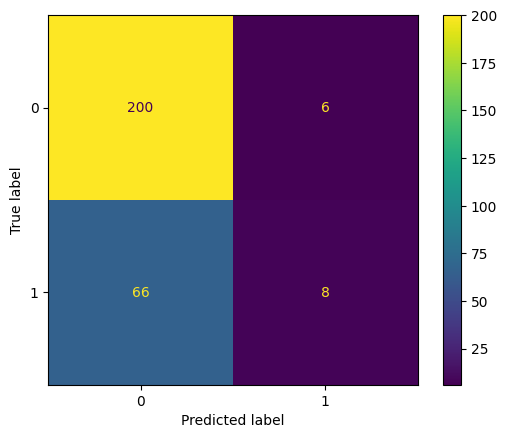

In [40]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_cMatrix, display_labels=CE_FIFS_model.classes_)
disp.plot()
plt.show()

*************

    Method 3: Modelling using feature selection based on feature importance values (SHAP Values)

In [18]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CE_binary_model)

In [19]:
#SHAP values for X_train
CE_shap_values = explainer.shap_values(CP_ER_X_train)

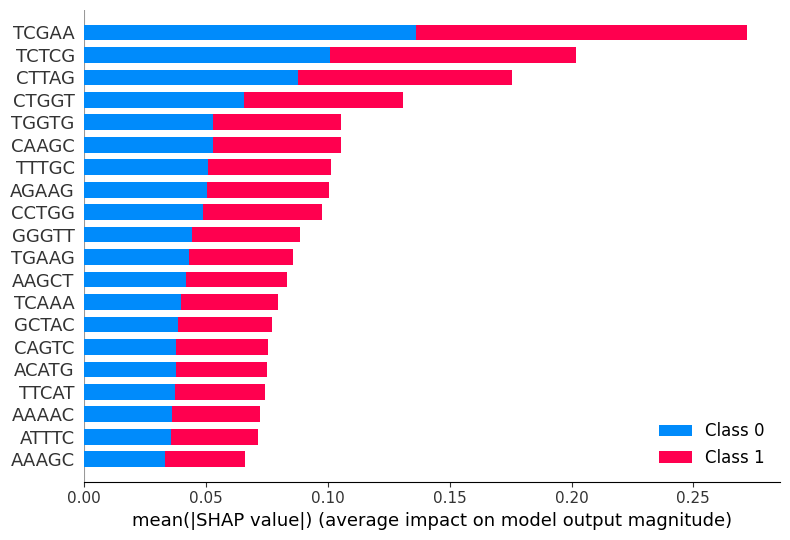

In [20]:
shap.summary_plot(CE_shap_values, CP_ER_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


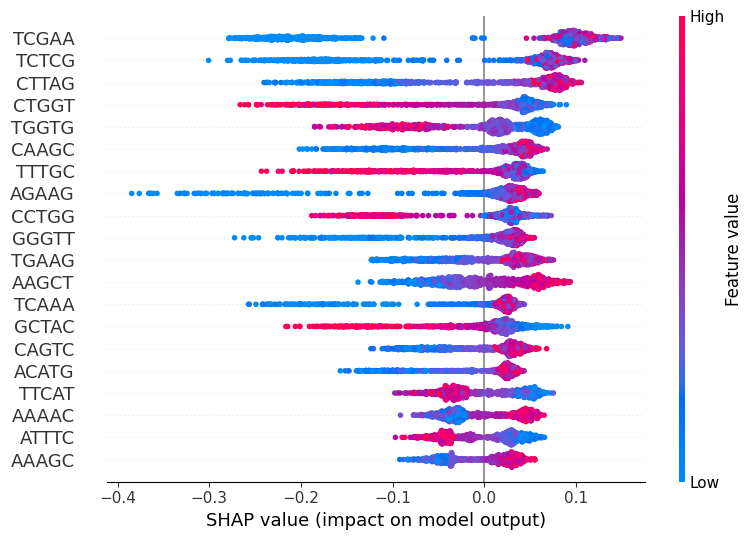

In [44]:
# Summary shap bar plot of Cytoplasm class (class 0)
shap.summary_plot(CE_shap_values[0], CP_ER_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


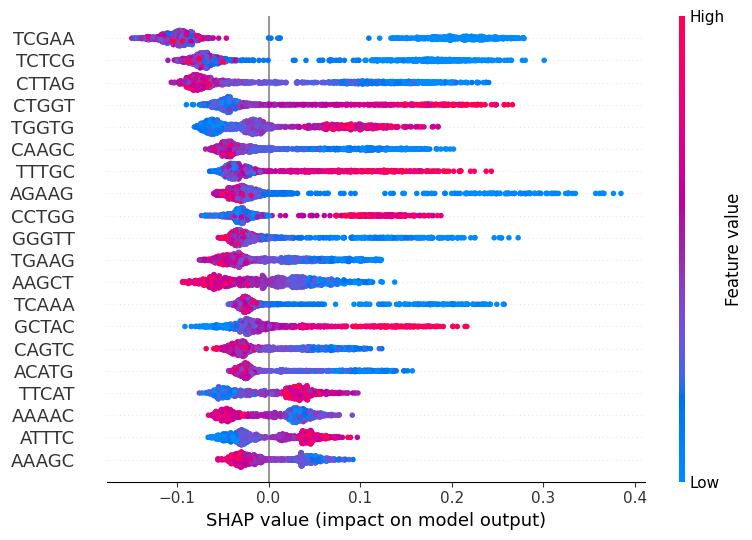

In [45]:
# Summary shap bar plot of Endoplasmic reticuum class (class 1)
shap.summary_plot(CE_shap_values[1], CP_ER_X_train, plot_size=0.2)

In [46]:
#Put values one one class into dataframe to use as reference values for FS
shap_df = pd.DataFrame(CE_shap_values[0], columns=CP_ER_X_train.columns)


In [47]:
# Calculate feature importance by only taking the values which 
CE_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [48]:
CE_shap_FI.head()

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,TCGAA,0.099348
1,TCTCG,0.069524
2,CTTAG,0.068141
3,GAGCC,0.048845
4,CTGGT,0.043455


In [49]:
# shap.summary_plot(CE_shap_values[0], CP_ER_X_train, show=False, max_display=30, plot_size=0.2)

In [50]:
#Classifier results with CE_feature_importance

In [51]:
from numpy import nansum
print("Sum of all shap feature importance values:", nansum(CE_shap_FI["Importances"]))

Sum of all shap feature importance values: 5.178115138192291


In [52]:
# Show only feature importances above 0.01 (0.03/3 = 0.01)

CE_SHAP_thres_chosen = CE_shap_FI[CE_shap_FI['Importances'] >= 0.01]
CE_shap_num_chosen = len(CE_SHAP_thres_chosen)

print(CE_SHAP_thres_chosen)

print("\nAmount of features with importance above 0.01 (selected features):", CE_shap_num_chosen)

    Feature Id  Importances
0        TCGAA     0.099348
1        TCTCG     0.069524
2        CTTAG     0.068141
3        GAGCC     0.048845
4        CTGGT     0.043455
..         ...          ...
98       TACCG     0.010437
99       GTGGA     0.010412
100      TTCCT     0.010323
101      TTGAG     0.010160
102      CTCTA     0.010130

[103 rows x 2 columns]

Amount of features with importance above 0.01 (selected features): 103


In [53]:
print("Sum of total feature importances: ", sum(CE_shap_FI.Importances))
print("Sum of feature importances >=0.01: ", sum(CE_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.01:  2.2176809439034626


In [54]:
# Select features with importance values above 0.1

CE_shap_selected_feat = CE_shap_FI[:CE_shap_num_chosen]['Feature Id'].tolist()

# print(CE_shap_selected_feat)

In [55]:
CP_ER_X_train.shape

(1120, 1024)

In [56]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [57]:
#Create training set with selected features 

CE_X_train_shap_selected = CP_ER_X_train[CE_shap_selected_feat]
CE_X_train_shap_selected.head()

,TCGAA,TCTCG,CTTAG,GAGCC,CTGGT,AAGCT,AAAAC,TTCAT,TGGTG,TCCAG,...,TTTCC,AAGCC,AAGAC,CAAAG,TGCAA,TACCG,GTGGA,TTCCT,TTGAG,CTCTA
0,0.000158,0.000792,0.000475,0.001267,0.000634,0.001426,0.000792,0.000634,0.001109,0.001426,...,0.001584,0.002218,0.000634,0.000950,0.001426,0.000158,0.001267,0.001742,0.001267,0.000792
1,0.000583,0.000583,0.000000,0.002040,0.000874,0.000874,0.000291,0.001166,0.001748,0.003205,...,0.000874,0.001457,0.000291,0.001457,0.000000,0.000000,0.001748,0.002622,0.001748,0.001457
2,0.000458,0.000458,0.000917,0.003208,0.001375,0.000458,0.001375,0.000000,0.001375,0.004125,...,0.002291,0.000458,0.000917,0.000917,0.000458,0.000000,0.000917,0.002291,0.000458,0.000458
3,0.000000,0.000000,0.000990,0.000495,0.000495,0.000000,0.000990,0.000000,0.001484,0.002969,...,0.000990,0.000000,0.000495,0.001979,0.000990,0.000000,0.000495,0.001484,0.000495,0.001484
4,0.000104,0.000415,0.000933,0.001037,0.000415,0.001244,0.002488,0.001555,0.001451,0.001555,...,0.001348,0.000415,0.001348,0.001140,0.000829,0.000207,0.001762,0.001140,0.001970,0.000933


In [58]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_shap_selected.columns) == CE_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [59]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 103)
Shape of y_train (number of labels): (1120,)


In [60]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_shap_selected_feat))

CE_shap_selected_train_pool = Pool(CE_X_train_shap_selected, CP_ER_y_train, feature_names=CE_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 103


In [61]:
#Create new model for data with selected features
CE_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CE_FIFS_shap_model.fit(CE_shap_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6717570	total: 19.4ms	remaining: 19.4s
1:	learn: 0.6525504	total: 40.7ms	remaining: 20.3s
2:	learn: 0.6327098	total: 59ms	remaining: 19.6s
3:	learn: 0.6174134	total: 74.7ms	remaining: 18.6s
4:	learn: 0.5993680	total: 89.5ms	remaining: 17.8s
5:	learn: 0.5821692	total: 106ms	remaining: 17.6s
6:	learn: 0.5677799	total: 120ms	remaining: 17s
7:	learn: 0.5558322	total: 133ms	remaining: 16.5s
8:	learn: 0.5445431	total: 147ms	remaining: 16.2s
9:	learn: 0.5338246	total: 161ms	remaining: 15.9s
10:	learn: 0.5228538	total: 175ms	remaining: 15.8s
11:	learn: 0.5133175	total: 191ms	remaining: 15.7s
12:	learn: 0.5044049	total: 206ms	remaining: 15.7s
13:	learn: 0.4968734	total: 222ms	remaining: 15.6s
14:	learn: 0.4905266	total: 236ms	remaining: 15.5s
15:	learn: 0.4833602	total: 251ms	remaining: 15.4s
16:	learn: 0.4759423	total: 265ms	remaining: 15.3s
17:	learn: 0.4677109	total: 278ms	remaining: 15.2s
18:	learn: 0.4626368	total: 291ms	remaining: 15s
19:	learn: 0

In [62]:
#Check parameters used in this model fit

CE_FIFS_shap_params = CE_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CE_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [63]:
#Prediction using X_test only for selected features data
CE_FIFS_shap_y_pred = CE_FIFS_shap_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_shap_y_prob = CE_FIFS_shap_model.predict_proba(CP_ER_X_test)

In [66]:
# Calculate F1 score and get classification report

print("Model 3: Feature selection (SHAP) - Cytoplasm & endoplasmic reticulum")

print("Number of chosen features:", len(CE_shap_selected_feat), "\n")

CE_FIFS_shap_cr = classification_report(CP_ER_y_test, CE_FIFS_shap_y_pred, digits=3)
print(CE_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_shap_y_pred))

CE_FIFS_shap_f1 = f1_score(CP_ER_y_test, CE_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {CE_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_shap_y_prob))

Model 3: Feature selection (SHAP) - Cytoplasm & endoplasmic reticulum
Number of chosen features: 103 

              precision    recall  f1-score   support

           0      0.760     0.971     0.853       206
           1      0.647     0.149     0.242        74

    accuracy                          0.754       280
   macro avg      0.704     0.560     0.547       280
weighted avg      0.730     0.754     0.691       280

Accuracy score:  0.7535714285714286

F1 Score: 0.5473183532885025


In [67]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_shap_y_pred.shape)

CE_FIFS_shap_y_pred_fl = CE_FIFS_shap_y_pred
print("flattened prediction values shape:", CE_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CE_FIFS_shap_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_shap_y_pred_fl)
print(CE_FIFS_shap_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[200   6]
 [ 63  11]]


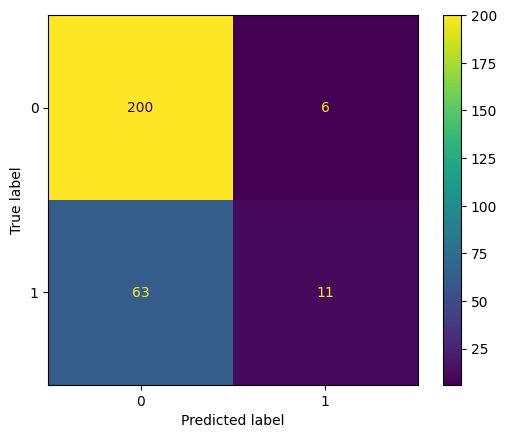

In [68]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_shap_cMatrix, display_labels=CE_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [ ]:
#Classifier results with newtry_feature_importance

In [114]:
#Try####
#Calculate feature importance from shap values by taking mean of absolute shap values for each feature
#Higher absolute shap value indicates greater contribution of that feature to the prediction task
vals= np.abs(CE_shap_values).mean(0)

newtry_feature_importance = pd.DataFrame(list(zip(CP_ER_X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
newtry_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
newtry_feature_importance

,col_name,feature_importance_vals
864,TCGAA,152.318754
886,TCTCG,113.035605
498,CTTAG,98.244182
491,CTGGT,73.192162
942,TGGTG,59.075172
...,...,...
306,CATAG,0.000000
645,GGACC,0.000000
816,TATAA,0.000000
302,CAGTG,0.000000


In [70]:
#View FI values for same amount of features selected in FIFS_shap method
# newtry_feature_importance.head(104)

In [91]:
# Show only feature importances above 0.1

CE_newSHAP_thres_chosen = newtry_feature_importance[newtry_feature_importance["feature_importance_vals"] > 0.01]
CE_newshap_num_chosen = len(CE_newSHAP_thres_chosen)

print(CE_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CE_newshap_num_chosen)

     col_name  feature_importance_vals
864     TCGAA               152.318754
886     TCTCG               113.035605
498     CTTAG                98.244182
491     CTGGT                73.192162
942     TGGTG                59.075172
...       ...                      ...
806     TAGCG                 0.251244
1020    TTTTA                 0.218695
206     ATATG                 0.211077
295     CAGCT                 0.182342
166     AGGCG                 0.041614

[987 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 987


In [75]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importance_vals))
print("Sum of feature importances >=0.1: ", sum(CE_newSHAP_thres_chosen.feature_importance_vals))

Sum of total feature importances:  6498.225728911477
Sum of feature importances >=0.1:  6498.225728911477


In [77]:
# Select features with importance values above 0.1

CE_newshap_selected_feat = newtry_feature_importance[:CE_newshap_num_chosen]['col_name'].tolist()

# print(CE_newshap_selected_feat)

In [78]:
CP_ER_X_train.shape

(1120, 1024)

In [79]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [80]:
#Create training set with selected features 

CE_X_train_newshap_selected = CP_ER_X_train[CE_newshap_selected_feat]
CE_X_train_newshap_selected.head()

,TCGAA,TCTCG,CTTAG,CTGGT,TGGTG,CAAGC,TTTGC,AGAAG,CCTGG,GGGTT,...,AAATT,ACCCT,CAGGC,TAAAG,GCAAC,TAGCG,TTTTA,ATATG,CAGCT,AGGCG
0,0.000158,0.000792,0.000475,0.000634,0.001109,0.001426,0.001109,0.001742,0.002059,0.000475,...,0.001901,0.000475,0.000317,0.001742,0.001584,0.000000,0.001584,0.000792,0.001901,0.000475
1,0.000583,0.000583,0.000000,0.000874,0.001748,0.000583,0.000291,0.004079,0.004953,0.000291,...,0.000000,0.002622,0.001748,0.000291,0.000583,0.000000,0.000291,0.000583,0.001457,0.001166
2,0.000458,0.000458,0.000917,0.001375,0.001375,0.000458,0.000458,0.002291,0.003208,0.000917,...,0.000458,0.002750,0.003208,0.000917,0.000000,0.000458,0.000917,0.000458,0.003208,0.000000
3,0.000000,0.000000,0.000990,0.000495,0.001484,0.001484,0.000000,0.000990,0.005443,0.000990,...,0.000495,0.000000,0.002969,0.000000,0.001484,0.000000,0.000495,0.000000,0.002474,0.001484
4,0.000104,0.000415,0.000933,0.000415,0.001451,0.000933,0.000933,0.001659,0.001140,0.001555,...,0.002695,0.000726,0.000933,0.001244,0.001140,0.000000,0.002695,0.001762,0.002281,0.000311


In [81]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_newshap_selected.columns) == CE_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [82]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 987)
Shape of y_train (number of labels): (1120,)


In [83]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_newshap_selected_feat))

CE_newshap_selected_train_pool = Pool(CE_X_train_newshap_selected, CP_ER_y_train, feature_names=CE_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 987


In [84]:
#Create new model for data with selected features
CE_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CE_FIFS_newshap_model.fit(CE_newshap_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6740823	total: 252ms	remaining: 4m 11s
1:	learn: 0.6503764	total: 392ms	remaining: 3m 15s
2:	learn: 0.6294382	total: 528ms	remaining: 2m 55s
3:	learn: 0.6143805	total: 655ms	remaining: 2m 43s
4:	learn: 0.5947276	total: 791ms	remaining: 2m 37s
5:	learn: 0.5806948	total: 930ms	remaining: 2m 34s
6:	learn: 0.5679427	total: 1.06s	remaining: 2m 30s
7:	learn: 0.5568848	total: 1.19s	remaining: 2m 27s
8:	learn: 0.5458080	total: 1.33s	remaining: 2m 26s
9:	learn: 0.5352455	total: 1.46s	remaining: 2m 24s
10:	learn: 0.5252260	total: 1.61s	remaining: 2m 24s
11:	learn: 0.5155585	total: 1.74s	remaining: 2m 23s
12:	learn: 0.5066153	total: 1.88s	remaining: 2m 22s
13:	learn: 0.4984279	total: 2s	remaining: 2m 20s
14:	learn: 0.4916835	total: 2.13s	remaining: 2m 20s
15:	learn: 0.4848284	total: 2.26s	remaining: 2m 18s
16:	learn: 0.4769818	total: 2.37s	remaining: 2m 17s
17:	learn: 0.4698186	total: 2.53s	remaining: 2m 17s
18:	learn: 0.4651795	total: 2.66s	remaining: 2m

In [85]:
#Check parameters used in this model fit

CE_FIFS_newshap_params = CE_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CE_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [86]:
#Prediction using X_test only for selected features data
CE_FIFS_newshap_y_pred = CE_FIFS_newshap_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_newshap_y_prob = CE_FIFS_newshap_model.predict_proba(CP_ER_X_test)

In [87]:
# Calculate F1 score and get classification report

CE_FIFS_newshap_f1 = f1_score(CP_ER_y_test, CE_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CE_FIFS_newshap_f1}")

CE_FIFS_newshap_cr = classification_report(CP_ER_y_test, CE_FIFS_newshap_y_pred, digits=3)
print(CE_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_newshap_y_prob))

F1 Score: 0.5305095866443099
              precision    recall  f1-score   support

           0      0.757     0.981     0.854       206
           1      0.692     0.122     0.207        74

    accuracy                          0.754       280
   macro avg      0.724     0.551     0.531       280
weighted avg      0.740     0.754     0.683       280

Accuracy score:  0.7535714285714286


In [88]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_newshap_y_pred.shape)

CE_FIFS_newshap_y_pred_fl = CE_FIFS_newshap_y_pred
print("flattened prediction values shape:", CE_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CE_FIFS_newshap_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_newshap_y_pred_fl)
print(CE_FIFS_newshap_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[202   4]
 [ 65   9]]


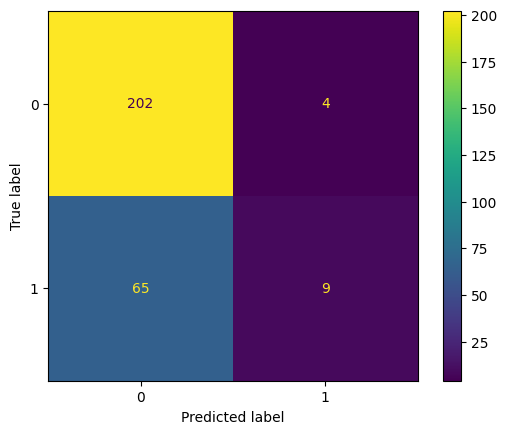

In [89]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_newshap_cMatrix, display_labels=CE_FIFS_newshap_model.classes_)
disp.plot()
plt.show()

*************
BELOW (POSSIBLY) NOT NECESSARY WHEN ABOVE IS USED
************